# Exercise 3 - Multi class Classification and NN

In [1]:
# %load ../../standard_import.txt
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt


# load MATLAB files
from scipy.io import loadmat
from scipy.optimize import minimize
from sklearn.preprocessing import PolynomialFeatures
import sys
from sklearn.linear_model import LogisticRegression
 
#%config InlineBackend.figure_formats = {'pdf',}
#%matplotlib inline

import seaborn as sns

%matplotlib inline


### Loading data 

X: (5000, 401) (with intercept)
y: (5000, 1)

Number of features (n): 401
Number of training examples (nm): 5000

theta1: (25, 401)
theta2: (10, 26)

Sample:





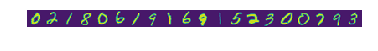

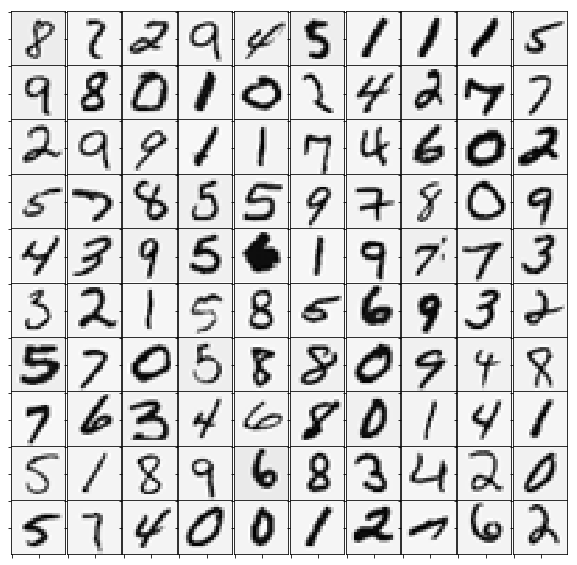

In [2]:
# Load data
data = loadmat('ex3data1.mat')
data.keys()

#Load the weights
weights = loadmat('ex3weights.mat')
weights.keys()


# Add x0 
X = np.c_[np.ones((data['X'].shape[0],1)), data['X']]
y = data['y']
m,n = X.shape
 
print('X: {} (with intercept)'.format(X.shape))
print('y: {}'.format(y.shape))

print('\nNumber of features (n): %.0f'%(n))
print('Number of training examples (nm): %.0f'%(m))

theta1, theta2 = weights['Theta1'], weights['Theta2']

print('\ntheta1: {}'.format(theta1.shape))
print('theta2: {}'.format(theta2.shape))

sample = np.random.choice(X.shape[0], 20)
print('\nSample:')
plt.imshow(X[sample,1:].reshape(-1,20).T)
plt.axis('off');
print('\n\n')

yy = data['y'].flatten()
XX = data['X']
# replace 10 -> 0 because Matlab is stupid
yy[np.flatnonzero(y == 10)] = 0
# set up array
fig, axarr = plt.subplots(nrows=10, ncols=10,
                              figsize=(10,10))
    
# loop over randomly drawn numbers
for ii in range(10):
    for jj in range(10):
        ind = np.random.randint(XX.shape[0])
        tmp = XX[ind,:].reshape(20,20, order='F')
        axarr[ii,jj].imshow(tmp, cmap='gray_r')
        plt.setp(axarr[ii,jj].get_xticklabels(), visible=False)
        plt.setp(axarr[ii,jj].get_yticklabels(), visible=False)
    
fig.subplots_adjust(hspace=0, wspace=0)



## Multiclass Logistic Regression

regularisationc can reduce the weight of the parameters in anywa function by increaseing the respective cost.
we edit the hypothesis to inflate the cost and thus reduce the fitting parameters

Note: \theta_0 is not to be regularised adn is calcualted seperately when using the vertorised method

Regularized Cost Function
for $\theta = 1,2,3,...n$
$$ J(\theta) = -\frac{1}{m}\bigg[\sum_{i=1}^{m}\big[y^{(i)} log( h_\theta(x^{(i)}))+(1-y^{(i)})log(1-h_\theta(x^{(i)}))\big] + \frac{\lambda}{2m}\sum_{j = 1}^{n}\theta_{j}^{2}\bigg]$$


Vectorized Cost Function
$$ J(\theta) = -\frac{1}{m}\big((log(h)^Ty+(log(1-h)^T(1-y)\big) + \frac{\lambda}{2m}\sum_{j = 1}^{n}\theta_{j}^{2}$$

Gradient Descent: Repeat until converge<br>
for j = 0 (The intercept is not regularised)
$$\theta_0 : = \theta_0- \alpha\frac{\partial J(\theta)}{\partial\theta_{0}}$$
for j = 1,2,3...n
$$\theta_j : = \theta_j- \alpha\Big[\Big(\frac{\partial J(\theta)}{\partial\theta_{j}}\Big) + \frac{\lambda}{m}\theta_{j}\Big] $$


Regularised Partial derivatives:<br>
for j = 0 
$$ \frac{\partial J(\theta)}{\partial\theta_{0}} = \frac{1}{m}\sum_{i=1}^{m} ( h_\theta (x^{(i)})-y^{(i)})x^{(i)}_{0} $$

for j = 1,2,3...m 
$$ \frac{\partial J(\theta)}{\partial\theta_{j}} = \frac{1}{m}\sum_{i=1}^{m} ( h_\theta (x^{(i)})-y^{(i)})x^{(i)}_{j} +\frac{\lambda}{m}\theta_{j}^{2}$$

Regularisaed & Vectorized Partial Derivative <br>
for j = 0 
$$\frac{\partial J(\theta)}{\partial\theta_{0}} = \frac{1}{m} X^T(h-y)$$
for j = 1,2,3... n
$$\frac{\partial J(\theta)}{\partial\theta_{j}} = \frac{1}{m} X^T(h-y) + \frac{\lambda}{m}\theta_{j}^{2}$$
where $h = g(X\theta)$

                                

### Regularised Cost Function

In [4]:
def sigmoid(z):
    g = 1 / (1 + np.exp(-z))
    return(g)
    
#logitic regression cost fucntion (Regularised)
def lrcostFunctionReg(theta, reg, X, y):
    """
    Computes the cost of using theta as the parameter for regularized
    logistic regression of the cost w.r.t. to the parameters.
    
    Parameters
    ----------
    theta : array_like
        Logistic regression parameters. A vector with shape (n, ). n is 
        the number of features including any intercept.  
    
    X : array_like
        The data set with shape (m x n). m is the number of examples, and
        n is the number of features (including intercept).
    
    y : array_like
        The data labels. A vector with shape (m, ).
    
    lambda_ : float
        The regularization parameter. 
    
    Returns
    -------
    J : float
        The computed value for the regularized cost function. 
    
    """
    m = y.size
    h = sigmoid(X.dot(theta))
    
    #cost fuinction
    J = -1 * (1/m) * (np.log(h).T.dot(y) + np.log(1 - h).T.dot(1 - y)) + (reg/(2 * m))*np.sum(np.square(theta[1:]))
    
    if np.isnan(J[0]):
        return(np.inf)
    return(J[0])    

# logistic regreession gradient of cost function
def lrgradientReg(theta, reg, X,y):
    """
    Computes the gradient of the cost using theta as the parameter for regularized
    logistic regression  w.r.t. to the parameters.
    
    Parameters
    ----------
    theta : array_like
        Logistic regression parameters. A vector with shape (n, ). n is 
        the number of features including any intercept.  
    
    X : array_like
        The data set with shape (m x n). m is the number of examples, and
        n is the number of features (including intercept).
    
    y : array_like
        The data labels. A vector with shape (m, ).
    
    lambda_ : float
        The regularization parameter. 
    
    Returns
    -------
    grad : array_like
    A vector of shape (n, ) which is the gradient of the cost
    function with respect to theta, at the current values of theta.
    """   
        
    m = y.size
    h = sigmoid(X.dot(theta.reshape(-1,1)))
     
    #Gradient
    grad = (1/m)*X.T.dot(h-y) + (reg/m)*np.r_[[[0]],theta[1:].reshape(-1,1)]
        
    return(grad.flatten())

### One - Vrs - All Prediction

In [6]:

# logistic regression - one - Vrs - all
def oneVsAll(features, classes, n_labels, reg):
    """
    Trains n_labels logistic regression classifiers and returns
    each of these classifiers in a matrix all_theta, where the i-th
    row of all_theta corresponds to the classifier for label i.
    
    Parameters
    ----------
    features : array_like
        The input dataset of shape (m x n). m is the number of 
        data points, and n is the number of features. Note that we 
        do not assume that the intercept term (or bias) is in X, however
        we provide the code below to add the bias term to X. 
    
    classes : array_like
        The data labels. A vector of shape (m, ).
    
    n_labels : int
        Number of possible labels.
    
    rag : float
        The logistic regularization parameter.
    
    Returns
    -------
    all_theta : array_like
        The trained parameters for logistic regression for each class.
        This is a matrix of shape (K x n+1) where K is number of classes
        (ie. `numlabels`) and n is number of features without the bias.
    """    
        
    initial_theta = np.zeros((X.shape[1],1))  # 401x1
    all_theta = np.zeros((n_labels, X.shape[1])) #10x401

    for c in np.arange(1, n_labels + 1):
        res = minimize(lrcostFunctionReg, initial_theta, args = (reg, features, (classes == c) * 1), 
                       method = None,jac = lrgradientReg, options = {'maxiter':50})
        all_theta[c - 1] = res.x
    return(all_theta)


theta = oneVsAll(X, y, 10, 0.1)


def predictOneVsAll(all_theta, features):
    """
    Return a vector of predictions for each example in the matrix X. 
    Note that X contains the examples in rows. all_theta is a matrix where
    the i-th row is a trained logistic regression theta vector for the 
    i-th class. You should set p to a vector of values from 0..K-1 
    (e.g., p = [0, 2, 0, 1] predicts classes 0, 2, 0, 1 for 4 examples) .
    
    Parameters
    ----------
    all_theta : array_like
        The trained parameters for logistic regression for each class.
        This is a matrix of shape (K x n+1) where K is number of classes
        and n is number of features without the bias.
    
    featured : array_like
        Data points to predict their labels. This is a matrix of shape 
        (m x n) where m is number of data points to predict, and n is number 
        of features without the bias term. Note we add the bias term for X in 
        this function. 
    
    Returns
    -------
    p : array_like
        The predictions for each data point in X. This is a vector of shape (m, ).
    """
    
    probs = sigmoid(X.dot(all_theta.T))
        
    # Adding one because Python uses zero based indexing for the 10 columns (0-9),
    # while the 10 classes are numbered from 1 to 10.
    return(np.argmax(probs, axis = 1) + 1)
 
pred = predictOneVsAll(theta, X)

print('Training set accuracy with Obe-Vrs_all: {} %'.format(np.mean(pred == y.ravel())*100))

Training set accuracy with Obe-Vrs_all: 93.24 %


### Multiclass Logistic Regression with scikit-learn

In [7]:
clf = LogisticRegression(C = 10, penalty='l2', solver='liblinear')
# Scikit-learn fits intercept automatically, so we exclude first column with 'ones' from X when fitting.
clf.fit(X[:,1:],y.ravel())

pred2 = clf.predict(X[:,1:])
print('Training set accuracy with sklearn: {} %'.format(np.mean(pred2 == y.ravel())*100))

Training set accuracy with sklearn: 96.5 %


### Neural Networks

In [10]:
def predict(theta_1, theta_2, features):
    """
    Predict the label of an input given a trained neural network.
    
    Parameters
    ----------
    Theta_1 : array_like
        Weights for the first layer in the neural network.
        It has shape (2nd hidden layer size x input size)
    
    Theta_2: array_like
        Weights for the second layer in the neural network. 
        It has shape (output layer size x 2nd hidden layer size)
    
    features : array_like
        The image inputs having shape (number of examples x image dimensions).
    
    Return 
    ------
    p : array_like
        Predictions vector containing the predicted label for each example.
        It has a length equal to the number of examples.
    """
    z2 = theta_1.dot(features.T)
    a2 = np.c_[np.ones((data['X'].shape[0],1)), sigmoid(z2).T]
    
    z3 = a2.dot(theta_2.T)
    a3 = sigmoid(z3)
        
    return(np.argmax(a3, axis=1)+1) 

pred3 = predict(theta1, theta2, X)
print('Training set accuracy: {} %'.format(np.mean(pred == y.ravel())*100))

Training set accuracy: 93.24 %


In [11]:
print('---------------------------------------')
print('\tSummary')
print('----------------------------------------')
print('Training set accuracy:')
print('\tMulti-class Logistical regression using One-Vrs-all {} %'.format(np.mean(pred == y.ravel())*100))
print('\tMulti-class Logistical regression using sklearn {} %'.format(np.mean(pred2 == y.ravel())*100))
print('\tMulti-class Logistical regression using Neural network {} %'.format(np.mean(pred3 == y.ravel())*100))




---------------------------------------
	Summary
----------------------------------------
Training set accuracy:
	Multi-class Logistical regression using One-Vrs-all 93.24 %
	Multi-class Logistical regression using sklearn 96.5 %
	Multi-class Logistical regression using Neural network 97.52 %
